In [1]:
import numpy as np
import pandas as pd
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Draw
from chembl_structure_pipeline import checker
from pathlib import Path  
from IPython.core.display import HTML
from rdkit.Chem.Draw import rdMolDraw2D
from io import BytesIO
import base64

# Data

In [33]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

In [2]:
df = pd.read_csv('data/db_mixed_7M_can.csv') 

In [3]:
df = df.drop(['Unnamed: 0','label'], axis=1)
df.head()

,ID,Smiles
0,CHEMBL1972157,B.CC(=O)OC1CN2CCC1CC2
1,CHEMBL209494,BC#N.BC#N.CN(C)CCCCCCCCCCCCCCN(C)C
2,CHEMBL210205,BC#N.BC#N.CN(C)CCCCCCCCCCCCN(C)C
3,CHEMBL209439,BC#N.BC#N.CN(C)CCCCCCCCCCN(C)C
4,CHEMBL213841,BC#N.C=CCCCCN(C)C


In [4]:
df = df.sample(n=1000000)

In [5]:
df = df.reset_index()

In [6]:
mols = [Chem.MolFromSmiles(m) for m in df.Smiles]

In [7]:
df = df.assign(mol=mols)

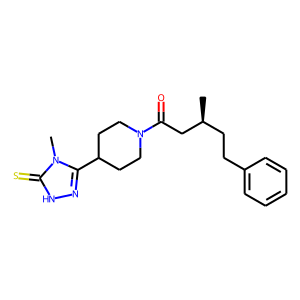

In [8]:
Draw.MolToImage(mols[0])

In [9]:
len(df)

1000000

# Data preprocesing - cleaninig smiles

In [10]:
def mol_display(mol):
    '''function to draw multiple molecules'''
    d = rdMolDraw2D.MolDraw2DCairo(400,400)
    d.DrawMolecule(mol)
    d.FinishDrawing()
    buffer = BytesIO(d.GetDrawingText())
    return f'<img src="data:image/png;base64,{base64.b64encode(buffer.getvalue()).decode()}">'

## Remove Stereochemistry

In [11]:
for mol in df.mol:
    Chem.rdmolops.RemoveStereochemistry(mol)

## Remove duplicates 

In [12]:
df = df.drop_duplicates()

In [14]:
len(df)

1000000

## Curation pipeline

In [15]:
issues = []
for mol in df.mol:
    o_molblock = Chem.rdmolfiles.MolToMolBlock(mol) 
    issues.append(checker.check_molblock(o_molblock))

In [16]:
with open('issues.txt', 'w') as f:
    for line in issues:
        f.write(' '.join(str(x) for x in line))
        f.write('\n')

In [17]:
# assign a maximum to each element
num = []
for iss in issues: # one element
    all_i = []
    [all_i.append(i[0]) for i in iss]
    if len(all_i) == 0:
        num.append(0)
    else:
        num.append(max(all_i))

In [18]:
df = df.assign(pipeline=num)

In [19]:
df['pipeline'].value_counts()

2    739669
0    257798
5      1337
6      1196
Name: pipeline, dtype: int64

In [20]:
filepath = Path('data/7Mpipeline.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
df.to_csv(filepath, index=False) 

In [21]:
df = pd.read_csv('data/7Mpipeline.csv')
df.drop('mol', inplace=True, axis=1)
df.head()

,index,ID,Smiles,pipeline
0,4389652,NaN,C[C@@H](CCc1ccccc1)CC(=O)N1CCC(c2n[nH]c(=S)n2C...,2
1,6393140,CHEMBL3545584,Nc1nc(-c2ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc2)c[nH]1,0
2,6514964,NaN,O=C(CN1C[C@@H]2CC(=O)Nc3cccc1c32)Nc1ccc2c(c1)C...,2
3,5863258,NaN,Cc1nnc(CN(C)[C@@H]2CCN(C(=O)c3n[nH]c(C)c3O)C2)o1,2
4,6147679,NaN,N#Cc1ccc([N+](=O)[O-])c(N[C@H]2CC[C@@H](O)C2)c1,2


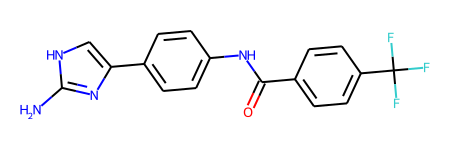

In [22]:
Chem.MolFromSmiles(df.Smiles[1])

In [23]:
df.Smiles = df.Smiles.apply(lambda x: x.split('.')[-1])

In [24]:
df.head()

,index,ID,Smiles,pipeline
0,4389652,NaN,C[C@@H](CCc1ccccc1)CC(=O)N1CCC(c2n[nH]c(=S)n2C...,2
1,6393140,CHEMBL3545584,Nc1nc(-c2ccc(NC(=O)c3ccc(C(F)(F)F)cc3)cc2)c[nH]1,0
2,6514964,NaN,O=C(CN1C[C@@H]2CC(=O)Nc3cccc1c32)Nc1ccc2c(c1)C...,2
3,5863258,NaN,Cc1nnc(CN(C)[C@@H]2CCN(C(=O)c3n[nH]c(C)c3O)C2)o1,2
4,6147679,NaN,N#Cc1ccc([N+](=O)[O-])c(N[C@H]2CC[C@@H](O)C2)c1,2


In [25]:
d = df.drop(df[df.pipeline > 2].index)

In [27]:
d['pipeline'].value_counts()

2    739669
0    257798
Name: pipeline, dtype: int64

In [28]:
filepath = Path('data/7Mfiltered.csv')  
filepath.parent.mkdir(parents=True, exist_ok=True)  
d.to_csv(filepath, index=False) 

In [29]:
df2 = d[d.pipeline == 2]
mols = [Chem.MolFromSmiles(m) for m in df2.Smiles]
df2 = df2.assign(mol=mols)

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 16. Change the maxMols value to display more.
  warnings.warn(


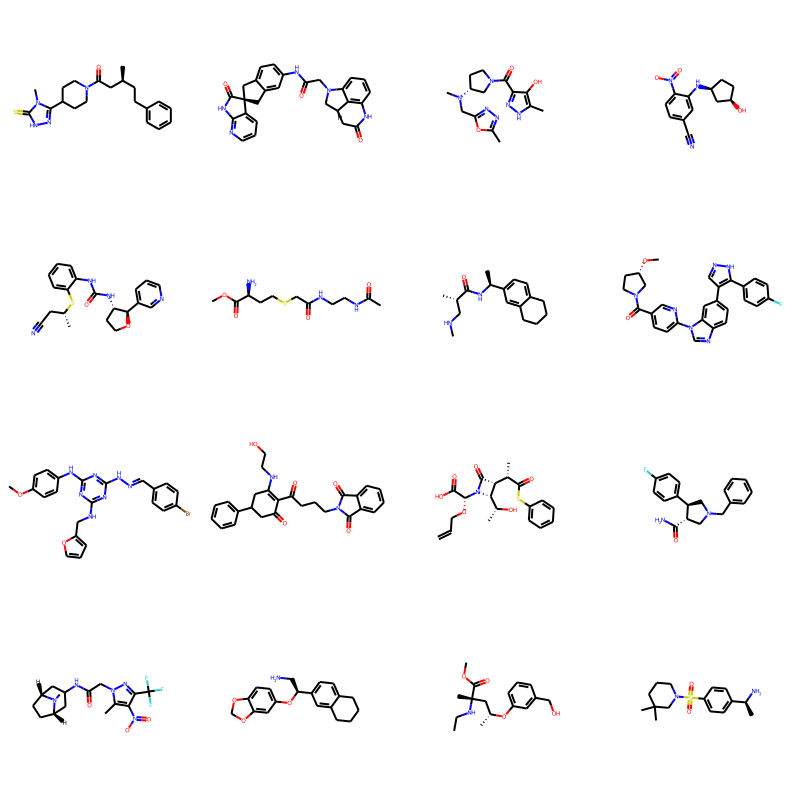

In [30]:
Draw.MolsToGridImage(df2['mol'], molsPerRow=4, maxMols=16)

### Problematic structures

Now, examining  the problematic structures.

In [31]:
df_problematic = df[df.pipeline > 2]
mols = [Chem.MolFromSmiles(m) for m in df_problematic.Smiles]
df_problematic = df_problematic.assign(mol=mols)

,mol,pipeline
207,,5
587,,6
869,,6
967,,6
1712,,5
2100,,5
2387,,5
2453,,5
2874,,6
2934,,6

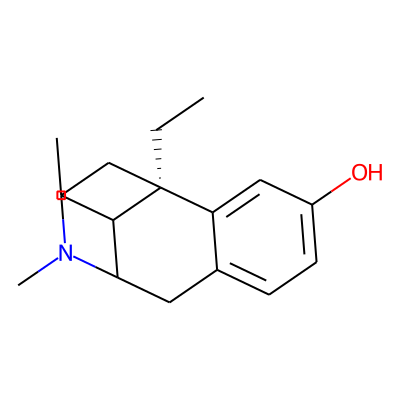
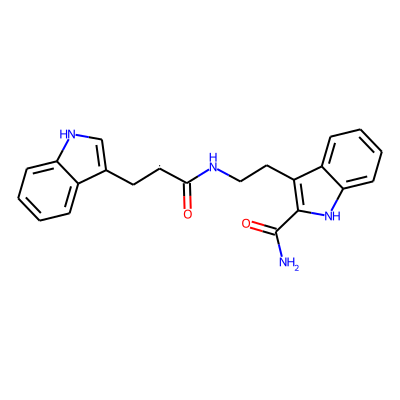
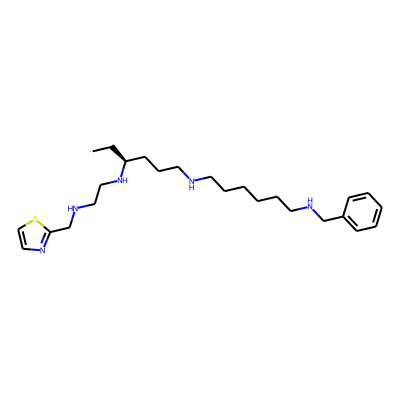
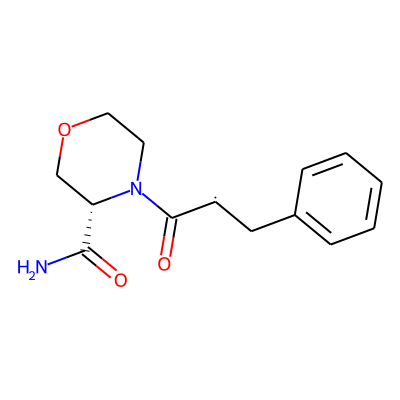
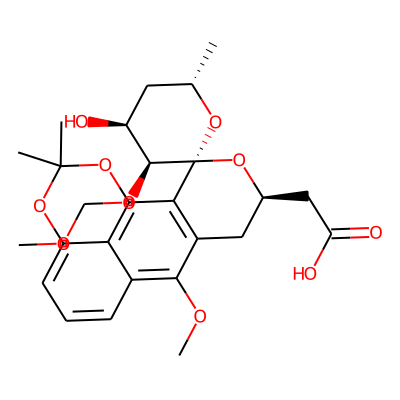
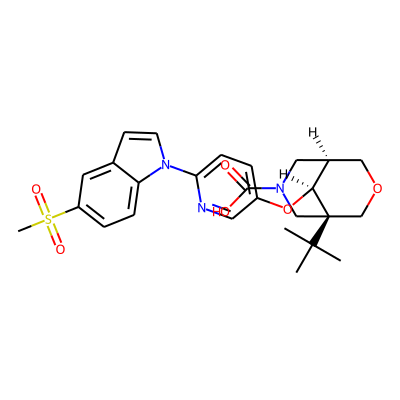
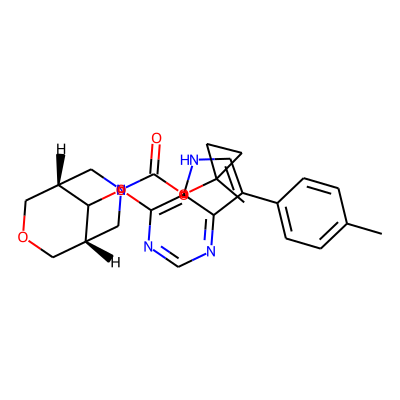
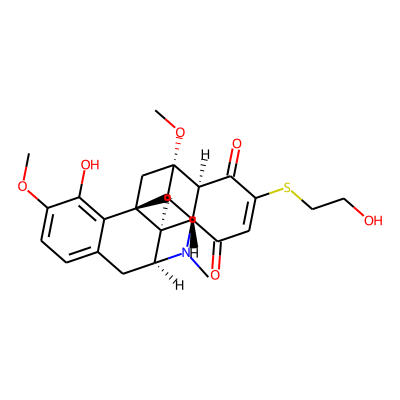
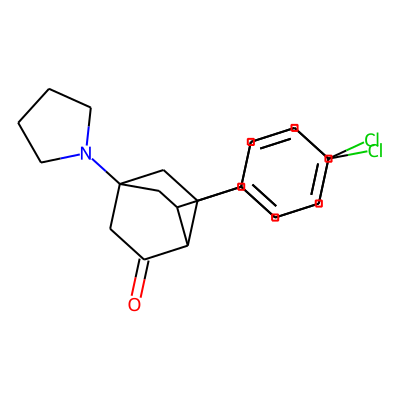
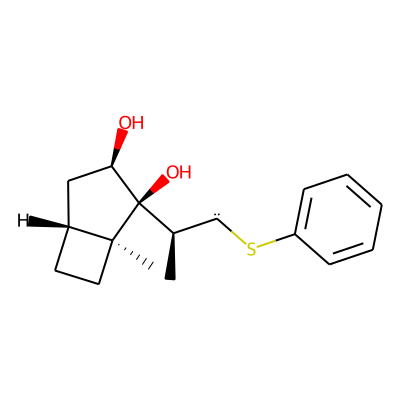
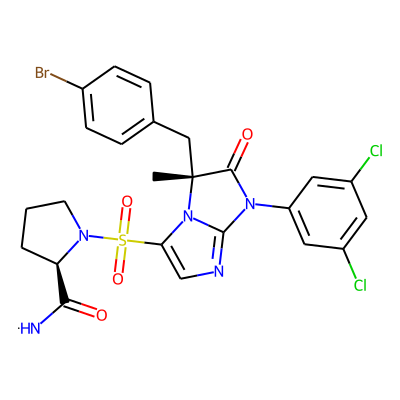
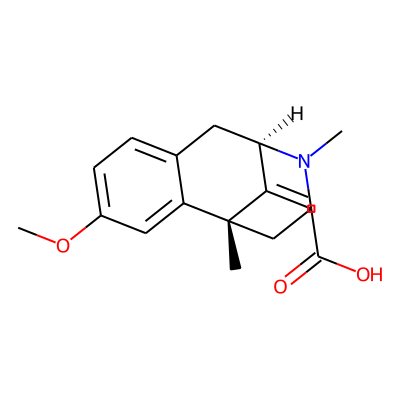
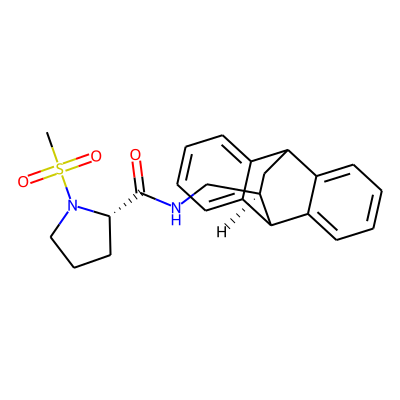
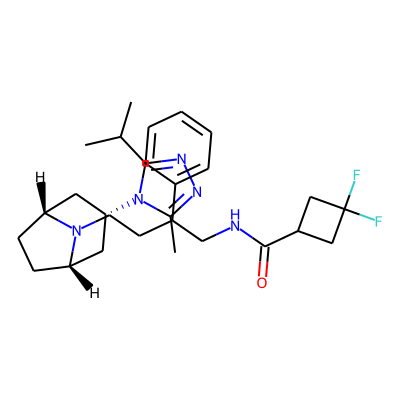
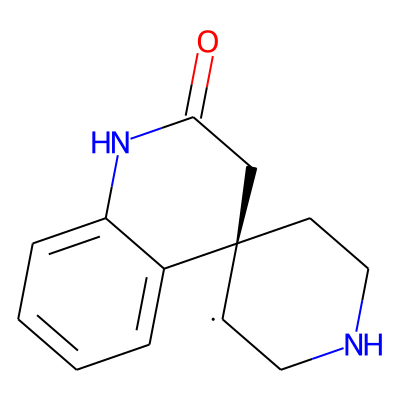
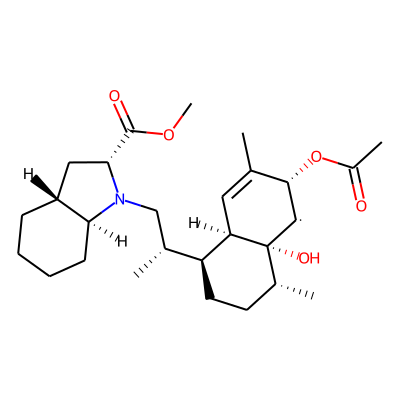
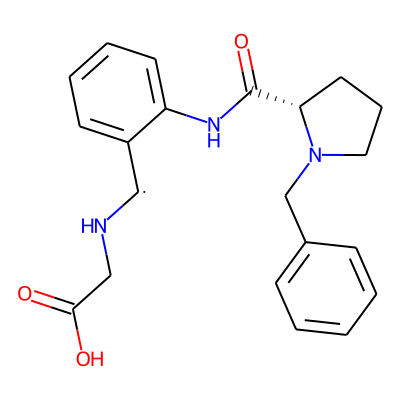
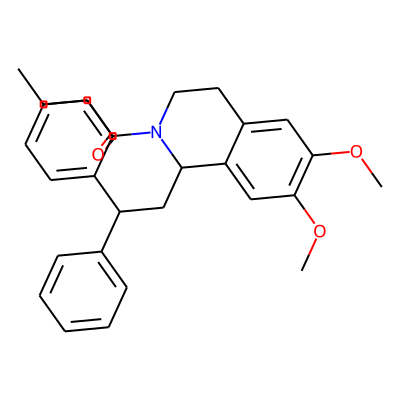
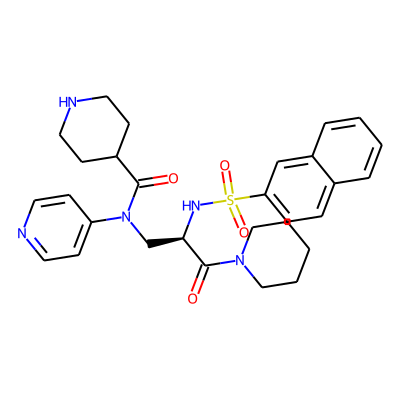
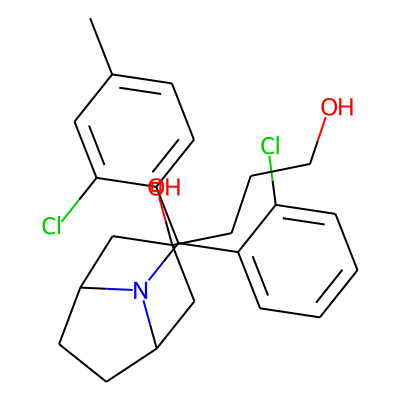
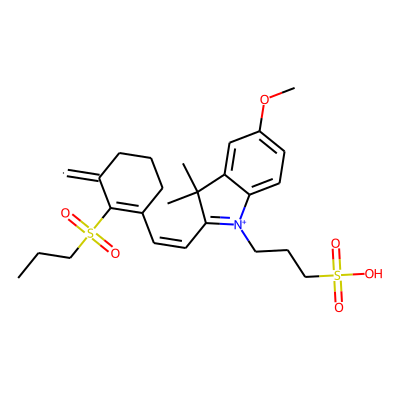
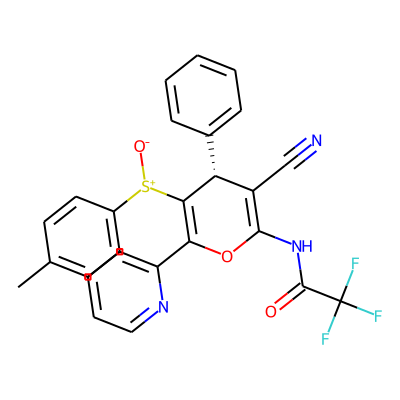
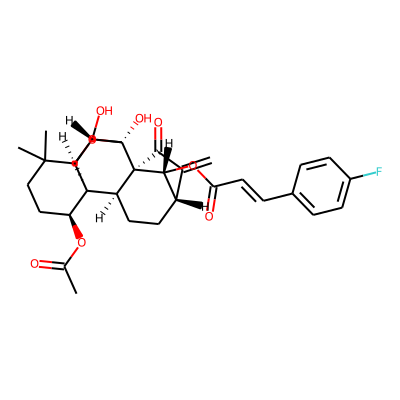
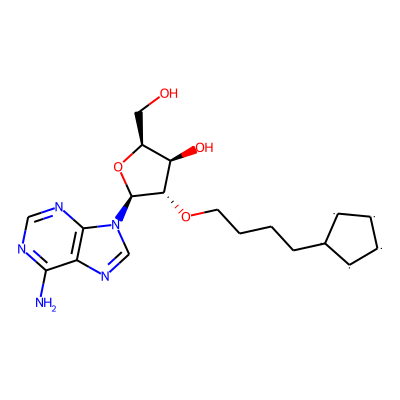
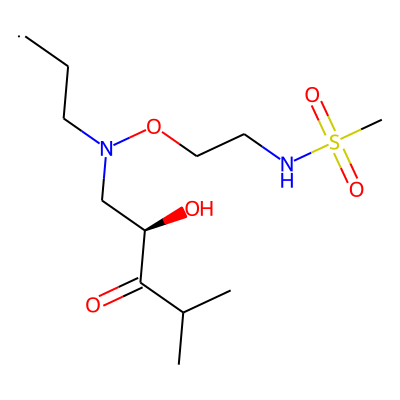
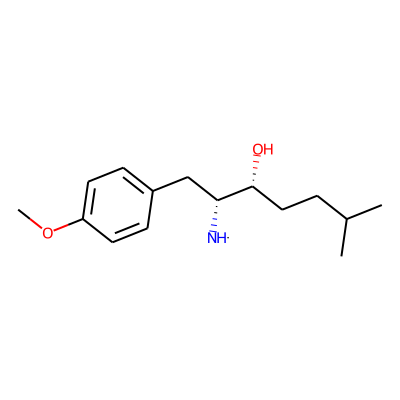
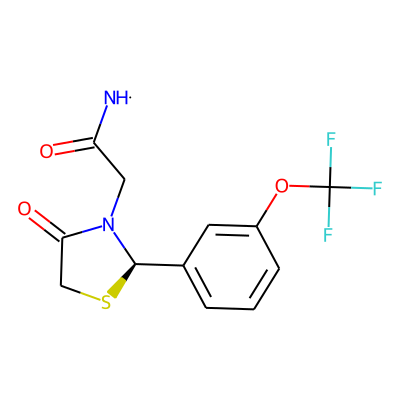
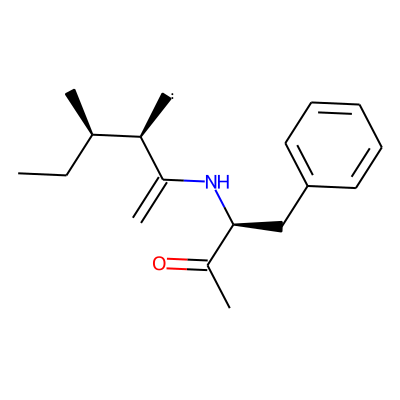
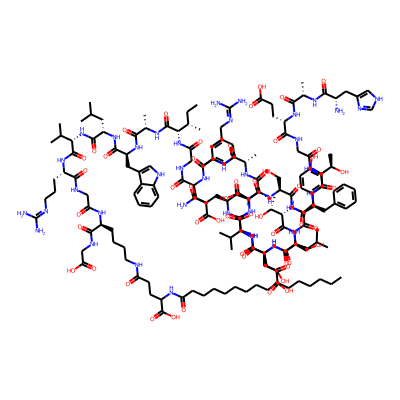
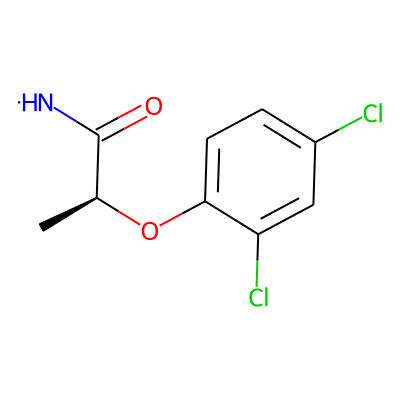

In [36]:
HTML(df_problematic[['mol','pipeline']].head(30).to_html(
    formatters={'mol': mol_display}, escape=False))

C:\Users\domiz\Miniconda3\envs\my-rdkit-env\lib\site-packages\rdkit\Chem\Draw\IPythonConsole.py:241: UserWarning: Truncating the list of molecules to be displayed to 16. Change the maxMols value to display more.
  warnings.warn(


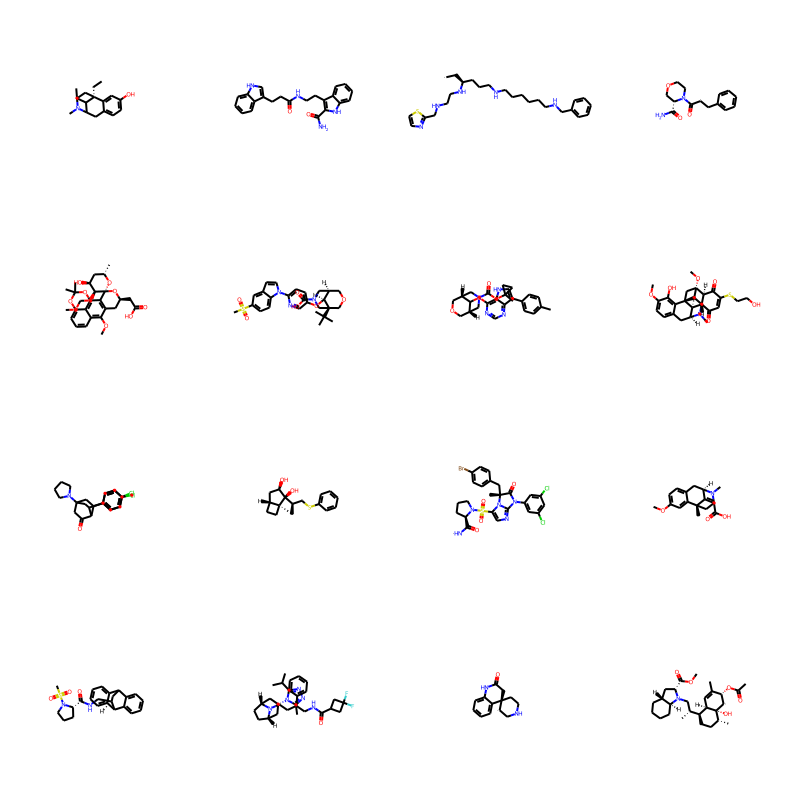

In [35]:
Draw.MolsToGridImage(df_problematic['mol'], molsPerRow=4, maxMols=16)